In [204]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.font_manager

# Cleaning of Data
from sklearn.model_selection import train_test_split

# For Outlier Detection
from sklearn.ensemble import IsolationForest

# Feature Selection
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.ensemble import ExtraTreesClassifier

# Regression Models
from sklearn.linear_model import LinearRegression 
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures, normalize

# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV 

# Error
from sklearn.metrics import r2_score

# Load datasets

In [178]:

# df_sample = pd.read_csv('sample.csv', float_precision = 'high').drop('id', axis=1) TODO

X = pd.read_csv('X_train.csv', float_precision = 'high').drop('id', axis=1)
y = pd.read_csv('y_train.csv', float_precision = 'high').drop('id', axis=1)


In [179]:
# replace all NaN 
X.fillna(X.median(), inplace=True)

# Outlier Detection - Isolation Forest

In [207]:
# Create model for isolation forest
clf = IsolationForest(behaviour = 'new', max_samples=100, random_state = 1, contamination= 'auto')

# Predict outliers
preds = clf.fit_predict(X)

# Remove outliers from dataset
X = X[preds==1]
y = y[preds==1]

In [208]:
# Split data with test_size = x% of the training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


# Feature Selection

## 1. Principal component analysis (PCA)

In [74]:
#Create the PCA model
#pca = PCA(n_components=800, svd_solver='full')
#reduced_X_train = pca.fit_transform(X_train)
#pca.explained_variance_ratio_
#reduced_X_train.shape

## 2. Uni-variate Selection

In [213]:
#apply SelectKBest class to extract top best features
bestfeatures = SelectKBest(score_func=f_regression, k=200)
fit = bestfeatures.fit(X_train,y_train.to_numpy().reshape(-1, ))

X_train_reduced = bestfeatures.transform(X_train)
X_test_reduced = bestfeatures.transform(X_test)

# Set up a DF for the scores to print
#featureScores = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(fit.scores_)],axis=1)
#featureScores.columns = ['Column No.','Score']
#top_scores = featureScores.nlargest(50,'Score')

# Reduce the dimentions/Select features for X
#X_train_reduced = X_train[top_scores['Column No.']]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


## 3. Feature Importance - ExtraTreesClassifier

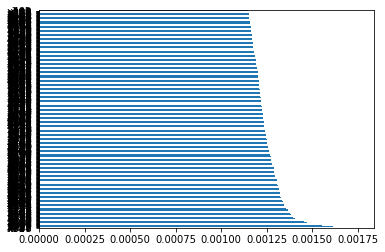

(829, 100)


In [165]:
# Create model
#model = ExtraTreesClassifier(n_estimators=100)
#model.fit(X_train,y_train.to_numpy().reshape(-1, ))

# Plot graph of feature importances for better visualization
#feat_importances = pd.Series(model.feature_importances_, index=X.columns)
#feat_importances.nlargest(100).plot(kind='barh')
#plt.show()

# Reduce the dimentions/Select features for X
#X_train_reduced = X_train[feat_importances.nlargest(100).index]

#print(X_train_reduced.shape)

In [215]:
# Normalize X_train

X_train_reduced = (X_train_reduced-X_train_reduced.mean())/X_train_reduced.std()
X_test_reduced = (X_test_reduced-X_train_reduced.mean())/X_train_reduced.std()

# Choosing the most correlated features

No handles with labels found to put in legend.


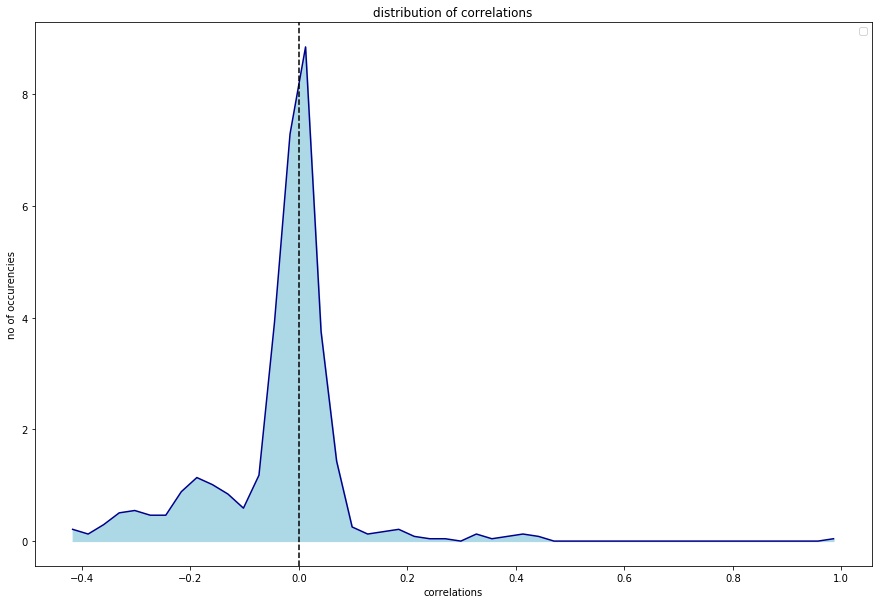

In [216]:
full_data = X_train.copy()
full_data['y'] = y_train

correlations = full_data.corr().y.dropna()

# plotting the distribution of feature importance
nbins = 50

n, bins = np.histogram(correlations.values, nbins, density=1)

pdfx, pdfy = np.zeros(n.size), np.zeros(n.size)

for k in range(n.size):
    pdfx[k], pdfy[k] = 0.5*(bins[k] + bins[k+1]), n[k]

plt.figure(figsize=(15,10))
plt.title('distribution of correlations')
plt.ylabel('no of occurencies')
plt.xlabel('correlations')

plt.plot(pdfx, pdfy, color = 'darkblue')
plt.fill_between(pdfx, pdfy, color = 'lightblue')

plt.axvline(x=0, color='k', linestyle='--')

plt.legend()
plt.show()

del full_data

# Hyperparameter tuning

In [217]:
# Instantiating the GridSearchCV object 
lasso_cv = GridSearchCV(Lasso(normalize=True), {'alpha': np.logspace(0.00001,1, num=10000) } , cv = 5) 
  
lasso_cv.fit(X_train_reduced, y_train)

# Print the tuned parameters and score 
print("Tuned Parameters: {}".format(lasso_cv.best_params_))  
print("Best score is {}".format(lasso_cv.best_score_)) 

Tuned Parameters: {'alpha': 1.0000230261160268}
Best score is -0.00809876323217722


In [218]:
def apply_lasso_regression(degree, X_train_param, y_train_param, X_test_param):
    
    # creating regression model
    model = Lasso(alpha=lasso_cv.best_params_['alpha'], normalize=True)
    
    # Generates a new feature matrix consisting of all polynomial combinations of the features with degree 
    # less than or equal to the specified degree. For example, if an input sample is two dimensional and of 
    # the form [a, b], the degree-2 polynomial features are [1, a, b, a^2, ab, b^2].
    polynomial_features = PolynomialFeatures(degree)
    X_train_poly = polynomial_features.fit_transform(X_train_param)
    
    # fitting the train data
    model.fit(X_train_poly, y_train_param/100)
    
    # making predictions for test data
    X_test_poly = polynomial_features.fit_transform(X_test_param)
    y_pred = model.predict(X_test_poly)

    #calculating the accuracy
    score = r2_score(y_test, y_pred*100)
    
    print('The obtained r2 score is : ',score)
        
    return model

# R2 - score

In [219]:
# creating regression model
#model = LinearRegression()
#model = Ridge(alpha=linreg_cv.best_params_['alpha'], fit_intercept=True)
   
# making predictions for train-test data
#y_pred = model.predict(pca.transform(X_test))
#y_pred = model.predict(bestfeatures.transform(X_test)
#y_pred = model.predict(X_test[feat_importances.nlargest(100).index])

#make sure to have reduced both X_train and X_test with the chosen feature selection method

model = apply_lasso_regression(1, X_train_reduced, y_train, X_test_reduced)

The obtained r2 score is :  -0.0021776078912545405


In [220]:
lasso_features_1 = X.columns[(np.abs(model.coef_) > 1e-5)[1:]]
lasso_features_2 = X.columns[(np.abs(model.coef_) > 1e-6)[1:]]
lasso_features_3 = X.columns[(np.abs(model.coef_) > 1e-7)[1:]]
lasso_features_4 = X.columns[(np.abs(model.coef_) > 1e-8)[1:]]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 832 but corresponding boolean dimension is 200

# Cross-Validation

In [ ]:
# Cross-validation of the results
cv_score = cross_val_score(model, X_train_reduced, y_train, cv=4)
print('The mean cross-validatin score is : ',cv_score.mean())
print(cv_score)

# Final test data 

In [175]:
# Load final test data
X_finaltest = pd.read_csv('X_test.csv', float_precision = 'high').drop('id', axis=1)

# Reduce final test data to fit feature selection 
#reduced_X_finaltest = pca.transform(X_finaltest)
reduced_X_finaltest = bestfeatures.transform(X_finaltest)

# Normalize 
reduced_X_finaltest = (reduced_X_finaltest-X_train_reduced.mean())/X_train_reduced.std()

df_sample['y'] = model.predict(reduced_X_finaltest)



ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [13]:
# output to csv
#df_sample[['id','y']].to_csv('result.csv')

# Neural Network

In [ ]:
# Splitting The Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

features_to_try = [correlated_features_1, correlated_features_2, correlated_features_3, correlated_features_4,
                   lasso_features_1, lasso_features_2, lasso_features_3, lasso_features_4]

scores = []

for features in features_to_try:
    # Normalizing the data

    # ----- Normalizing X values -----
    X_train_normalized = X_train[correlated_features_1]
    X_test_normalized = X_test[correlated_features_1]

    # Normalizing the X values
    X_train_normalized = (X_train_normalized - X_train_normalized.mean()) / X_train_normalized.std()
    X_test_normalized = (X_test_normalized - X_test_normalized.mean()) / X_test_normalized.std()

    # Making X numpy arrays
    X_train_normalized = X_train_normalized.values
    X_test_normalized = X_test_normalized.values

    # ----- Normalizing y values -----
    y_mean, y_std = y.mean()[0], y.std()[0]

    y_train_normalized = ((y_train - y_mean) / y_std).values
    
    # Training the Neural Network
    
    n = X_train_normalized.shape[1]

    model = Sequential([Dense(n, activation='relu'),
                        Dense(1024, activation='relu'),
                        Dense(512, activation='relu'),
                        Dropout(0.1),
                        Dense(1024, activation='relu'),
                        Dense(1024, activation='relu'),
                        Dropout(0.1),
                        Dense(1024, activation='relu'),
                        Dropout(0.1),
                        Dense(512, activation='relu'),
                        Dense(256, activation='relu'),
                        Dense(1)])

    model.compile(loss='mean_absolute_error', optimizer='adam')
    model.fit(X_train_normalized, y_train_normalized, epochs=30)
    
    # Predicting values
    y_pred = model.predict(X_test_normalized)
    y_pred = y_pred*y_std + y_mean
    
    # Saving the score
    score = r2_score(y_test, y_pred)
    scores.append(score)

In [ ]:
for i, score in enumerate(scores):
    print('The obtained r2 score when using {}-th features is: {}'.format(i,score))